<a href="https://colab.research.google.com/github/Swathi1309/ED18B034_ME18B133_CS6910/blob/main/Assignment3/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import Model
from keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout, TimeDistributed, Lambda, Activation, Reshape,\
Softmax, Multiply, AdditiveAttention, Concatenate, Add, RepeatVector
import tarfile
import random
from keras.optimizers import RMSprop, Adam, SGD
from keras.utils import to_categorical

from math import log
from numpy import array, argmax
import sklearn

import pprint

In [ ]:
!pip install wandb
!wandb login
import wandb
from wandb.keras import WandbCallback
wandb.init(project="assg3", entity='cs6910_project')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Examples



```
# This is formatted as code
```

File extraction

In [ ]:
my_tar = tarfile.open('/content/drive/MyDrive/Dakshina dataset/dakshina_dataset_v1.0.tar')
my_tar.extractall('/content/drive/MyDrive/Dakshina dataset') # specify which folder to extract to
my_tar.close()

Examples

In [ ]:
import csv
hi_to_eng = open("/content/drive/MyDrive/Dakshina dataset/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv")
read_tsv = csv.reader(hi_to_eng, delimiter="\t")
i=0
for row in read_tsv:
  i +=1
  print(row)
  if i==30:
    break
hi_to_eng.close()

# Loading datasets

In [2]:
def load_data(data_path, data):
  input_texts=[]
  target_texts = []
  global tk_input, tk_target, num_input_tokens, num_target_tokens
  
  with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
  for line in lines[: (len(lines) - 1)]:
    input_text, target_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
  
  # random.seed(10)
  # random.shuffle(input_texts)
  # random.seed(10)
  # random.shuffle(target_texts)
     
  if (data == "train"):
    tk_input = keras.preprocessing.text.Tokenizer(num_words=None, char_level=True)
    tk_input.fit_on_texts(input_texts)
    enc_input = tk_input.texts_to_sequences(input_texts)
    enc_input = tf.keras.preprocessing.sequence.pad_sequences(enc_input, padding='post')

    tk_target = keras.preprocessing.text.Tokenizer(num_words=None, char_level=True)
    tk_target.fit_on_texts(target_texts)
    dec_target = tk_target.texts_to_sequences(target_texts)
    dec_target = tf.keras.preprocessing.sequence.pad_sequences(dec_target, padding='post')

    dec_input = np.zeros(dec_target.shape)
    dec_input[:,:(dec_target.shape[1]-1)] = dec_target[:,1:]
  
  else:
    enc_input = tk_input.texts_to_sequences(input_texts)
    enc_input = tf.keras.preprocessing.sequence.pad_sequences(enc_input, padding='post', maxlen = max_input_length)

    dec_target = tk_target.texts_to_sequences(target_texts)
    dec_target = tf.keras.preprocessing.sequence.pad_sequences(dec_target, padding='post', maxlen = max_target_length)

    dec_input = np.zeros(dec_target.shape)
    dec_input[:,:(dec_target.shape[1]-1)] = dec_target[:,1:]
  
  return enc_input, dec_target, dec_input

In [5]:
data_path_train = "/content/drive/MyDrive/Dakshina dataset/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.train.tsv"
data_path_dev = '/content/drive/MyDrive/Dakshina dataset/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.dev.tsv'
data_path_test = '/content/drive/MyDrive/Dakshina dataset/dakshina_dataset_v1.0/hi/lexicons/hi.translit.sampled.test.tsv'

global enc_input_train, dec_input_train, dec_target_train, enc_input_dev, dec_input_dev, dec_target_dev
global tk_input, tk_target, reverse_input_char_index, reverse_target_char_index
global input_token_train, output_token_train, max_input_length, max_target_length
global y_true_dev, y_true_train
global classes

# Loading datasets
enc_input_train, dec_input_train, dec_target_train = load_data(data_path_train,'train')

max_input_length = enc_input_train.shape[1]
max_target_length = dec_target_train.shape[1]

num_input_tokens = len(tk_input.word_index)+1
num_target_tokens = len(tk_target.word_index)+1

enc_input_dev, dec_input_dev, dec_target_dev = load_data(data_path_dev,'dev')
enc_input_test, dec_input_test, dec_target_test = load_data(data_path_test,'test')

# One hot encoding of target outputs
y_true_dev = np.zeros((dec_target_dev.shape[0],dec_target_dev.shape[1], num_target_tokens))
for i in range(0,dec_target_dev.shape[0]):
  y_true_dev[i] = to_categorical(dec_target_dev[i], num_classes = num_target_tokens)

y_true_train = np.zeros((dec_target_train.shape[0],dec_target_train.shape[1], num_target_tokens))
for i in range(0,dec_target_train.shape[0]):
  y_true_train[i] = to_categorical(dec_target_train[i], num_classes = num_target_tokens)

# Integer to character dictionary
reverse_input_char_index = dict((i, char) for char, i in tk_input.word_index.items())
reverse_target_char_index = dict((i, char) for char, i in tk_target.word_index.items())

# Defining classes
classes = ["0"]
for i in range(1,29):
  classes.append(reverse_target_char_index[i])

# Defining functions

Training models

In [6]:
# Encoder
def encoder(enc_out,enc_block, latent_dim, enc_layers):
  states = []
  for i in range(0,enc_layers):
    if enc_block =='LSTM':
      enc_out ,h ,c = LSTM(latent_dim, return_state=True, return_sequences=True, name='encoder'+str(i))(enc_out)
      s = [h,c]
      states.append(s)
    elif enc_block =='GRU':
      enc_out ,s = GRU(latent_dim, return_state=True, return_sequences=True, name='encoder'+str(i))(enc_out)
      states.append(s)
    else:
      enc_out ,s = SimpleRNN(latent_dim, return_state=True, return_sequences=True, name='encoder'+str(i))(enc_out)
      states.append(s)
    
  return enc_out,states

# Decoder
def decoder(X_input_dec, hs_init, latent_dim, dec_block, dec_layers, dense_no, drop_no, attn):
  out_dec = X_input_dec
  hs = hs_init
  for i in range (0,dec_layers):
    if i == 0 and attn == True:
      hs[i] = None
    if dec_block == 'LSTM':
      out_dec, h, s = LSTM(latent_dim, return_sequences=True, return_state=True, name='decoder'+str(i))(out_dec, initial_state = hs[i])
    elif dec_block == 'GRU':
      out_dec, _ = GRU(latent_dim, return_sequences=True, return_state=True, name='decoder'+str(i))(out_dec, initial_state = hs[i])
    else:
      out_dec, _ = SimpleRNN(latent_dim, return_sequences=True, return_state=True, name='decoder'+str(i))(out_dec, initial_state = hs[i])
  
  if dense_no != 0:
    out_dec = TimeDistributed(Dense(dense_no, activation="relu", name = 'output'), name = 'dense_hidden')(out_dec)
    out_dec = Dropout(drop_no)(out_dec)
  out_dec = TimeDistributed(Dense(num_target_tokens, activation="softmax", name = 'output'), name = 'dense')(out_dec)
  
  return out_dec

# Bahnadau Attention
def b_attention(latent_dim):
  query_in = keras.Input((latent_dim,))
  values_in = keras.Input((max_input_length,latent_dim))
  query = Reshape((1,latent_dim), name='query_reshape')(query_in)
  score_unit2 = Dense(num_target_tokens, name='score_unitq')(query)
  score_unit1 = Dense(num_target_tokens, name='score_unitv')(values_in)
  score_unit12 = Add()([score_unit1, score_unit2])
  score_unit12 = Activation('tanh')(score_unit12)
  score = Dense(1)(score_unit12)
  attention_weights = Softmax(axis=1)(score)
  context_vector = Multiply()([attention_weights,values_in])
  context_vector = Lambda(lambda x: tf.reduce_sum(x,axis=1))(context_vector)
  context_vector = RepeatVector(max_target_length)(context_vector)

  model = Model(inputs = [query_in,values_in], outputs = [context_vector, attention_weights], name='attention')
  return model

# Final RNN model for training
def RNN_model(embedding_no, enc_block, latent_dim, dec_block, dense_no, drop_no, enc_layers, dec_layers):
  X_input_enc = keras.Input(shape=(max_input_length,))
  X_input_dec = keras.Input(shape=(max_target_length,))
  X_enc = tf.keras.layers.Embedding(num_input_tokens, embedding_no, name = 'embedding_enc')(X_input_enc)
  X_dec = tf.keras.layers.Embedding(num_target_tokens, embedding_no, name = 'embedding_dec')(X_input_dec)
  _,s_init = encoder(X_enc,enc_block, latent_dim, enc_layers)
  out_dec = decoder(X_dec,s_init, latent_dim, dec_block, dec_layers, dense_no, drop_no, False)
  model = Model(inputs = [X_input_enc,X_input_dec], outputs = out_dec, name = 'train_model')
  return model

# Final RNN model with attention for training
def RNN_w_att(embedding_no, enc_block, latent_dim, dec_block, dense_no, drop_no, enc_layers, dec_layers):
  X_input_enc = keras.Input(shape=(max_input_length,))
  X_input_dec = keras.Input(shape=(max_target_length,))

  X_enc = tf.keras.layers.Embedding(num_input_tokens, embedding_no, name = 'embedding_enc')(X_input_enc)
  X_dec = tf.keras.layers.Embedding(num_target_tokens, embedding_no, name = 'embedding_dec')(X_input_dec)

  values,s_init = encoder(X_enc,enc_block, latent_dim, enc_layers)
  context_vector, weights = b_attention(latent_dim)([s_init[len(s_init)-1][0], values])
  X_dec = Concatenate(name = 'concatenate')([context_vector,X_dec])

  out_dec = decoder(X_dec,s_init, latent_dim, dec_block, dec_layers, dense_no, drop_no, True)
  model = Model(inputs = [X_input_enc,X_input_dec], outputs = out_dec, name = 'train_model')

  return model

Inference models

In [7]:
# Encoder model for inference
def enc_inference(model,enc_layers,rnn_block):
  X_enc = model.input[0]
  X_in_enc = model.get_layer('embedding_enc')(X_enc)
  enc_outputs = X_in_enc
  states = []
  if rnn_block == 'LSTM':
    for i in range(0,enc_layers):
      enc_outputs, h_enc, s_enc = model.get_layer('encoder'+str(i))(enc_outputs)
      states.append([h_enc, s_enc])
  else:
    for i in range(0,enc_layers):
      enc_outputs, s_enc = model.get_layer('encoder'+str(i))(enc_outputs)
      states.append(s_enc)
  
  enc_model = keras.Model(inputs = X_enc, outputs = [enc_outputs, states])
  return enc_model

# Decoder model for inference
def dec_inference(model, latent_dim, dec_layers, rnn_block, attn, embedding_dim):
  if attn==True:
    dec_inputs = keras.Input(shape=(max_target_length, latent_dim+embedding_dim))
    dec_outputs = dec_inputs
  else:
    dec_inputs = model.input[1]
    dec_outputs = model.get_layer('embedding_dec')(dec_inputs)
  hs_inputs = []
  # print(tf.shape(dec_outputs))
  
  if rnn_block == 'LSTM':
    for i in range(0,dec_layers):
      h = keras.Input(shape=(latent_dim,))
      c = keras.Input(shape=(latent_dim,))
      hs_inputs.append([h,c])
    hs_outputs = []
    for i in range(0,dec_layers):
      if i == 0 and attn == True:
        dec_outputs, h_dec, s_dec = model.get_layer('decoder'+str(i))(dec_outputs)
        hs_outputs.append([h_dec,s_dec])
      else:
        dec_outputs, h_dec, s_dec = model.get_layer('decoder'+str(i))(dec_outputs, initial_state = hs_inputs[i])
        hs_outputs.append([h_dec,s_dec])

  else:
    for i in range(0,dec_layers):
      c = keras.Input(shape=(latent_dim,))
      hs_inputs.append(c)
    hs_outputs = []
    for i in range(0,dec_layers):
      dec_outputs, s_dec = model.get_layer('decoder'+str(i))(dec_outputs, initial_state = hs_inputs[i])
      hs_outputs.append(s_dec)

  dec_dense = model.get_layer('dense')
  dec_outputs = dec_dense(dec_outputs)
  dec_model = keras.Model(inputs = [dec_inputs, hs_inputs], outputs = [dec_outputs, hs_outputs])  
  return dec_model

Decoder functions

In [8]:
# Greedy decoder
def greedy_decoder(enc_inf, dec_inf, input_seq, rnn_block):
  _, states = enc_inf.predict(input_seq)
  target_seq = np.zeros((input_seq.shape[0],1))
  target_seq[:,0] = tk_target.word_index["\t"]
  pred = [[tk_target.word_index["\t"]] for _ in range (input_seq.shape[0])]
  
  if rnn_block == 'LSTM':
    for i in range(max_target_length):
      output_tokens, state_final = dec_inf.predict([target_seq, states])
      x = np.argmax(output_tokens, axis=-1)
      target_seq = x
      for j in range(input_seq.shape[0]):
        pred[j].append(target_seq[j][0])
      states = state_final

  else:
    for i in range(max_target_length):
      output_tokens, c = dec_inf.predict([target_seq, states])
      x = np.argmax(output_tokens, axis=-1)
      target_seq = x
      for j in range(input_seq.shape[0]):
        pred[j].append(target_seq[j][0])
      states = c

  return pred

# Beam search function
def beam_search(enc_inf, dec_inf, input_seq, k):
  _, states = enc_inf.predict(input_seq)
  target_seq = np.zeros((k,1))
  target_seq[:,0] = tk_target.word_index["\t"]
  pred = [[[tk_target.word_index["\t"]], 0.0] for _ in range (k)]

  for i in range(max_target_length):
    all_candidates = list()
    output_tokens, state_final = dec_inf.predict([target_seq, states])
    states = state_final
    for j in range(len(pred)):
      seq, score = pred[j]
      for l in range(output_tokens.shape[-1]):
        candidate = [seq + [l], score - log(output_tokens[j][0][l])]
        all_candidates.append(candidate)
      if i==0:
        break
    ordered = sorted(all_candidates, key=lambda tup:tup[1])
    pred = ordered[:k]
    for j in range (k):
      target_seq[j] = pred[j][0][i+1]

  final_pred = ordered[:1]
  return (final_pred[0][0])

# Beam search decoder
def beam_search_decoder(enc_inf, dec_inf, input_seq, k):
  pred = []
  for i in range(input_seq.shape[0]):
    input = input_seq[i:i+1,:]
    input = np.concatenate((input,)*k, axis = 0)
    pred.append(beam_search(enc_inf, dec_inf, input, k))
    if i%100 == 0:
      print((i/input_seq.shape[0])*100)
  return pred

Word accuracy metric

In [9]:
def word_accuracy(true_words, pred_words):
  count = len([i for i, j in zip(true_words, pred_words) if i==j])
  return count/len(pred_words)

Encoding to Word conversion

In [10]:
def transliteration(inputs):
  start = tk_target.word_index["\t"]
  end = 0
  words = []
  for i in range(len(inputs)):
    start_index = inputs[i].index(start)
    try:
      end_index = inputs[i].index(end)
      temp = inputs[i][start_index+1:end_index]
    except ValueError:
      temp = inputs[i][start_index+1:]
    word = (list(map(reverse_target_char_index.__getitem__, temp)))
    if (word[-1]=="\n"):
      word.pop(-1)
    separator = ''
    word_new = separator.join(word)
    words.append(word_new)
  return words

# Sweeps

In [ ]:
sweep_config = {
    'method': 'grid'
    }

parameters_dict = {
    'embedding_no':{
        'values': [512]
      },
    'rnn_block':{
        'values': ['LSTM']
      },
    'no_of_layers': {
        'values': [2]
      },
    'latent_dimension': {
        'values': [512]
      },
    'hidden_layer': {
        'values': [0]
      },
    'dropout': {
        'values': [0]
      },
    'beam_search': {
        'values': [4, 2]
      },
    'epochs' : {
        'values' : [20]
      },
    'optimizer' : {
        'values' : ['rmsprop']
      },
    'learning_rate' : {
        'values' : [1e-3]
      },
    'attention' : {
        'values' : [False]
    }
}

sweep_config['parameters'] = parameters_dict
pprint.pprint(sweep_config)

def training_sweep(config=None):
    with wandb.init(config=config):
        config = wandb.config
        if config.attention == True:
          model = RNN_w_att(config.embedding_no, config.rnn_block, config.latent_dimension, config.rnn_block,
                            config.hidden_layer, config.dropout, config.no_of_layers, config.no_of_layers)
        else:
          model = RNN_model(config.embedding_no, config.rnn_block, config.latent_dimension, config.rnn_block,
                            config.hidden_layer, config.dropout, config.no_of_layers, config.no_of_layers)
        
        if config.optimizer == 'adam':
          opt = Adam(config.learning_rate)
        else:
          opt = RMSprop(config.learning_rate)
        model.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics=['accuracy'])

        # #model.fit([enc_input_train,dec_input_train], y_true_train, 
        #                     epochs=config.epochs,
        #                     validation_data = ([enc_input_dev,dec_input_dev], y_true_dev),
        #                     callbacks = [WandbCallback()]
        #                     )

        name = str(config.rnn_block) + '_' + str(config.no_of_layers) + '_' + str(config.embedding_no) + '_' + str(config.latent_dimension) + '_' + str(config.hidden_layer) + '_' + str(config.epochs)
        location = '/content/drive/MyDrive/Transliteration/' + name
        model.save(location)

        enc_inf = enc_inference(model, config.no_of_layers, config.rnn_block)
        dec_inf = dec_inference(model, config.latent_dimension, config.no_of_layers, config.rnn_block, config.attention, config.embedding_no)

        if (config.beam_search!=0):
          predictions = beam_search_decoder(enc_inf, dec_inf, enc_input_dev, config.beam_search)
        else:
          predictions = greedy_decoder(enc_inf, dec_inf, enc_input_dev, config.rnn_block)

          # word_acc = word_accuracy(dec_target_dev,np.array(predictions))
          # word_acc = sklearn.metrics.accuracy_score(dec_target_dev,np.array(predictions))
          pred_words = transliteration(predictions)

          true = list(list(dec_input_dev[i]) for i in range(dec_input_dev.shape[0]))
          true_words = transliteration(list(true))
          word_acc = word_accuracy(true_words, pred_words)
          wandb.log({'word_level_accuracy': word_acc})

{'method': 'grid',
 'parameters': {'attention': {'values': [False]},
                'beam_search': {'values': [4, 2]},
                'dropout': {'values': [0]},
                'embedding_no': {'values': [512]},
                'epochs': {'values': [20]},
                'hidden_layer': {'values': [0]},
                'latent_dimension': {'values': [512]},
                'learning_rate': {'values': [0.001]},
                'no_of_layers': {'values': [2]},
                'optimizer': {'values': ['rmsprop']},
                'rnn_block': {'values': ['LSTM']}}}


In [ ]:
sweep_id = wandb.sweep(sweep_config, project="assg3")
wandb.agent(sweep_id, training_sweep)

# Plotting confusion matrix

In [11]:
def labels(true_words, pred_words):
  true = []
  pred = []
  for i in range(len(true_words)):
    word1 = true_words[i]
    word2 = pred_words[i]
    len1 = len(word1)
    len2 = len(word2)
    
    for letter1 in word1:
      true.append(tk_target.word_index[letter1])
    for letter2 in word2:
      pred.append(tk_target.word_index[letter2])
    
    if len1<len2:
      for i in range(len2-len1):
        true.append(0)
    if len1>len2:
      for i in range(len1-len2):
        pred.append(0)

  return true, pred

def confusion_matrix(true, pred):
  wandb.log({"conf_mat" : wandb.plot.confusion_matrix(probs=None, y_true=true, preds=pred, class_names=classes)})

In [ ]:
true, pred = labels(true_words, pred_words)
confusion_matrix(true,pred)

# Rest of the code

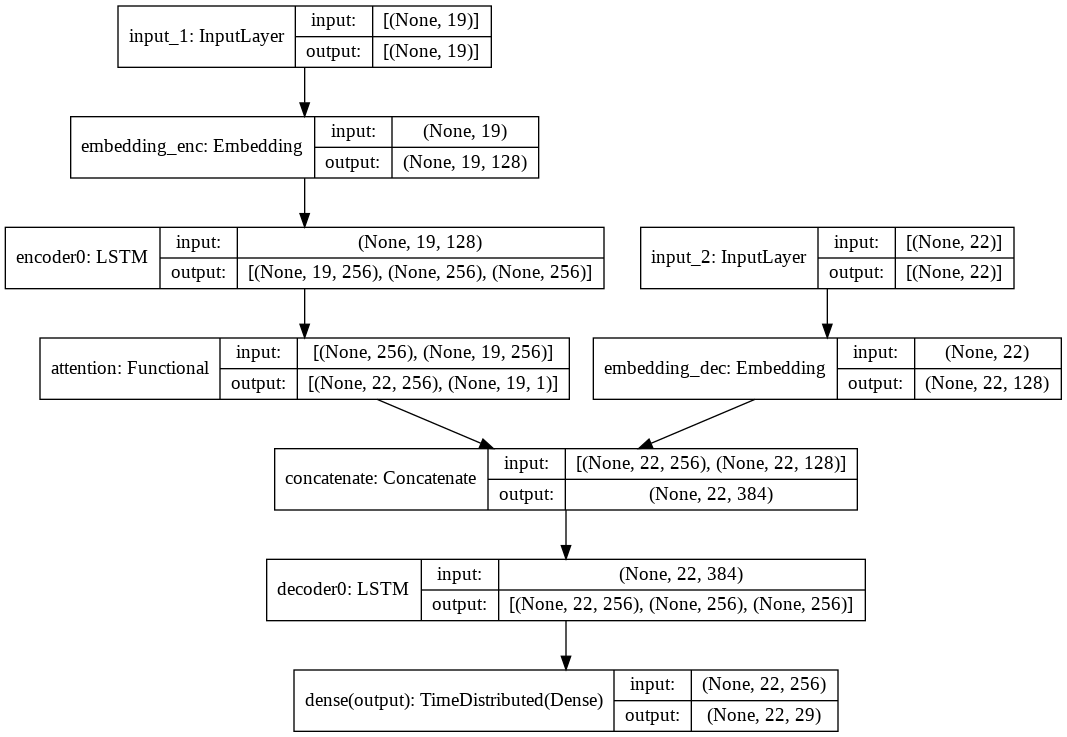

In [12]:
model= RNN_w_att(128,'LSTM',256,'LSTM',0,0,1,1)
keras.utils.plot_model(model,show_shapes=True, rankdir='TB')

In [ ]:
att_model = b_attention(256)
keras.utils.plot_model(att_model,show_shapes=True, rankdir='TB')

In [ ]:
model = RNN_model(256, 'LSTM', 512, 'LSTM', 0, 0, 1, 1)
# keras.utils.plot_model(model,show_shapes=True, rankdir='TB')

In [21]:
model.compile(optimizer=RMSprop(1e-2), loss = 'categorical_crossentropy', metrics=['accuracy'])
model.fit([enc_input_train,dec_input_train], y_true_train, 
          batch_size = 128,epochs=20, validation_data=([enc_input_dev,dec_input_dev], y_true_dev))

Epoch 1/20
346/346 [==============================] - 10s 19ms/step - loss: 0.1575 - accuracy: 0.9489 - val_loss: 0.1693 - val_accuracy: 0.9470
Epoch 2/20
346/346 [==============================] - 6s 17ms/step - loss: 0.1311 - accuracy: 0.9564 - val_loss: 0.1765 - val_accuracy: 0.9427
Epoch 3/20
346/346 [==============================] - 6s 17ms/step - loss: 0.1221 - accuracy: 0.9581 - val_loss: 0.1577 - val_accuracy: 0.9502
Epoch 4/20
346/346 [==============================] - 6s 17ms/step - loss: 0.1148 - accuracy: 0.9600 - val_loss: 0.1602 - val_accuracy: 0.9486
Epoch 5/20
346/346 [==============================] - 6s 17ms/step - loss: 0.1102 - accuracy: 0.9615 - val_loss: 0.1602 - val_accuracy: 0.9493
Epoch 6/20
346/346 [==============================] - 6s 17ms/step - loss: 0.1065 - accuracy: 0.9621 - val_loss: 0.1578 - val_accuracy: 0.9508
Epoch 7/20
346/346 [==============================] - 6s 17ms/step - loss: 0.1033 - accuracy: 0.9628 - val_loss: 0.1602 - val_accuracy: 0.950

In [ ]:
enc_inf = enc_inference(model, 1, "LSTM")
dec_inf = dec_inference(model, 256, 1, 'LSTM', True, 128)
att_inf = model.get_layer('attention')

predictions, weights = greedy_decoder_attn(enc_inf, dec_inf, enc_input_dev)

pred_words = transliteration(predictions)

print ("hello")
true = list(list(dec_target_dev[i]) for i in range(dec_target_dev.shape[0]))
true_words = transliteration(list(true))
word_acc = word_accuracy(true_words, pred_words)

In [27]:
word_acc

0.0029830197338228544

In [ ]:
model = RNN_w_att(256, 'LSTM', 512, 'LSTM', 0, 0, 2, 2)
enc_inf = enc_inference(model, 2,'LSTM')
dec_inf = dec_inference(model, 512, 2, 'LSTM')
att_inf = model.get_layer('attention')

In [39]:
inputs = tf.random.normal([1, 384, 128])
dec = LSTM(256, return_sequences=True, return_state=True)
out, h, c = dec(inputs, initial_state=None)
print(out.shape)

(1, 384, 256)


In [24]:
def greedy_decoder_attn(enc_inf, dec_inf, input_seq):
  values, s_init = enc_inf.predict(input_seq)
  target_seq = np.zeros((input_seq.shape[0],22))
  target_seq[:,0] = tk_target.word_index["\t"]

  pred = [[tk_target.word_index["\t"]] for _ in range (input_seq.shape[0])]

  attention_weights = []
  for i in range(max_target_length):
    context_vector, weights = att_inf.predict([s_init[len(s_init)-1][0], values])
    attention_weights.append(weights)

    output_tokens = Concatenate()([context_vector, model.get_layer('embedding_dec')(target_seq)])
    output_tokens, state_final = dec_inf.predict([output_tokens, s_init])
    x = np.argmax(output_tokens[:,0,:], axis = -1)

    for j in range(input_seq.shape[0]):
      target_seq[j][0] = x[j]
      print(target_seq[j][0])
      pred[j].append(target_seq[j][0])
    s_init = state_final

  return pred, weights